# Table of Contents

1. Outline of the Finance Problem and Numerical Procedure  
   1.1 Options  
   1.2 Procedure  

2. Code

3. Results, Comparison, Observation, and Problems  
   3.1 Base Case Scenario  
   3.2 Testing Sensitivity to Volatility  
   3.3 Testing Sensitivity to Interest Rate (Drift)  
   3.4 Testing Sensitivity to Strike Price  
   3.5 Testing Sensitivity to Stock Price  
   3.6 Testing Sensitivity to Time to Expiry

4. Conclusion

5. References

## Outline & numerical procedure

Task: Using the Euler-Maruyama scheme for simulating underlying stock price. Price Asian and lookback options in various scenarios using the expected value of the discounted payoff under the risk-neutral density Q:
$$V(S,t) = e^{-r(T - t)} \mathbb{E}^{\mathbb{Q}}[\text{Payoff}(S_T)]$$  
As per Singaravelu (2024) we start with assuming the stock price follows geometric Brownian Motion which we can express with the stochastic differential equation:
$$dS_t = r S_t dt + \sigma S_t dW_t$$  
This is in continuos time, but we can follow the same procedure as Ahmad (2024) to discretize the function. Using the Euler-Maruyama scheme we can discretize this process as such:
$$S_{t+\Delta t} = S_t \exp\left( (r - 0.5 \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)$$  
We can define the time to expiry T-t and how long one time step (delta t) should be. In this case we will go with the start off with the assumption of time to expiry T-t = 1 year, and simulate daily stock prices with the assumption that there are 252 trading days in a year. Which means that for any given stock price path we will simulate 252 prices (1 per trading day), we could use lower or higher cadence but for this exercise we will focus on varying other assumptions.

### Options
We are tasked to consider 2 different exotic options, Asian and Lookback options. These options are strongly path dependent according to Ahmad (2024) which means they have more dimensions than vanilla options and we have to keep track of extra variables such as mean/maximum/minimum. With strong path dependant options Monte Carlo is a good method to price the options. These exotics come in different varietes. For both option types we can have fixed or floating strikes. With a fixed strike the strike is known at the time the option is written, a floating strike is dependent on the price path. Furthermore for the asian option we can take either the arithmatic mean or the geometric mean. (Singaravelu (2024))  
We can define arithmetic mean as: 
$$S_\text{ari} = \frac{1}{N} \sum_{i=1}^N S_{t_i}$$
And geometric mean as:
$$S_{\text{geo}} = \left( \prod_{i=1}^{N} S_{t_i} \right)^{\frac{1}{N}}$$

#### Asian
First lets consider the Asian option. An asian option takes the average stock price during a given period instead of the price at expiry like a vanilla option. Like Singaravelu (2024) discusses there are different kinds of asian options, for example the average can be defined either as the geometric average or the arithmetic average. And we can do a floating or a fixed strike option.

We can then express the Payoff for an arithmetic average Asian option like this:  
Call fixed strike: 
$$\text{C}_{\text{Asian, Fixed}} = \max\left(S_\text{ari} - E, 0\right)$$
Put fixed strike: 
$$\text{P}_{\text{Asian, Fixed}} = \max\left(E - S_\text{ari}, 0\right)$$
Geometric versions:  
Call fixed strike: 
$$\text{C}_{\text{Asian, Fixed}} = \max\left(S_\text{geo} - E, 0\right)$$  
Put fixed strike: 
$$\text{P}_{\text{Asian, Fixed}} = \max\left(E - S_\text{geo}, 0\right)$$  

Similarirly we can do it with floating strikes:  
Call floating strike: 
$$\text{C}_{\text{Asian, Float}} = \max(S_T - S_{\text{ari}}, 0)$$  
Put floating strike: 
$$\text{P}_{\text{Asian, Float}} = \max(S_{\text{ari}} - S_T , 0)$$  
Geometric versions:  
Call floating strike: 
$$\text{C}_{\text{Asian, Float}} = \max(S_T - S_{\text{geo}}, 0)$$  
Put floating strike: 
$$\text{P}_{\text{Asian, Float}} = \max(S_{\text{geo}} - S_T , 0)$$  

#### Lookback
The lookback option looks back at the history of the stockprice during the period and defines the stock price as the maximum price for the given period for a call option and the minimum price for a put option. We can then express a call lookback option as:
$$\text{C}_{\text{Lookback, fixed}} = \max\left(S_{\text{max}} - E, 0\right)$$
Put: 
$$\text{P}_{\text{Lookback, fixed}} = \max\left( E - S_{\text{min}}, 0\right)$$

It can also be done with a floating strike where the strike becomes the maximum or minimum stock price during the life of the option. Call:
$$\text{C}_{\text{Lookback, Float}} = \max(S_T - S_{\text{min}}, 0)$$
Put: 
$$\text{P}_{\text{Lookback, Float}} = \max(S_{\text{max}} - S_T, 0)$$

### Procedure
We know have set up what we need to price these options. Which we can do by (1) Simulating the stockprices with the Euler-Maruyama scheme, (2) calculate the payoff of the different options in each path. (3) Average the payoffs of all of the simulated paths to come up with an expected value. And lastly (4) discount the expected backoff using $\text{discount\_factor} = e^{-rT}$.(Singaravelu (2024), Ahmad (2024))



### Data inputs and scenarios
We can start with the following data assumptions:

Todays stock price $S_0 = 100$  
Strike $E = 100$  
Time to expiry $(T-t) = 1$ year  
Volatility $\sigma = 20\%$  
Constant risk-free interest rate $r = 5%$  

And then vary the assumptions to explore how those variations in data impact the option value. To vary the inputs I will use the follow ranges:

$S_0 \in [50, 150] \text{ with step size of 5 }$  
$E \in [50, 150] \text{ with step size of 5 }$  
$(T - t) \in [0.5, 5.0] \text{ with step size of 0.5 } $  
$\sigma \in [5\%, 50\%] \text{ with step size of 5\%} $  
$r \in [0\%, 10\%] \text{ with step size of } 1\%$  

## Code

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Create a function to simulate stock price and then price the different options on those price paths
def simulate_and_price_option(S0, E, sigma, r, T, M, N):
    dt = T / N # Time step
    discount_factor = np.exp(-r * T) # discount factor
    
    # Simulate stock paths using Euler-Maruyama scheme
    stock_paths = np.zeros((M, N + 1))
    stock_paths[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        stock_paths[:, t] = stock_paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    S_T = stock_paths[:, -1]
    
    # Arithmetic and geometric averages, minimum, and maximum
    arithmetic_avg = np.mean(stock_paths[:, 1:], axis=1)
    geometric_avg = np.exp(np.mean(np.log(stock_paths[:, 1:]), axis=1))
    S_max = np.max(stock_paths[:, 1:], axis=1)
    S_min = np.min(stock_paths[:, 1:], axis=1)

    # Pricing the options by taking the average payoff across paths and applying the discount factor
    asian_call_fixed_arith = discount_factor * np.mean(np.maximum(arithmetic_avg - E, 0))
    asian_put_fixed_arith = discount_factor * np.mean(np.maximum(E - arithmetic_avg, 0))
    asian_call_floating_arith = discount_factor * np.mean(np.maximum(S_T - arithmetic_avg, 0))
    asian_put_floating_arith = discount_factor * np.mean(np.maximum(arithmetic_avg - S_T, 0))
    asian_call_fixed_geo = discount_factor * np.mean(np.maximum(geometric_avg - E, 0))
    asian_put_fixed_geo = discount_factor * np.mean(np.maximum(E - geometric_avg, 0))
    asian_call_floating_geo = discount_factor * np.mean(np.maximum(S_T - geometric_avg, 0))
    asian_put_floating_geo = discount_factor * np.mean(np.maximum(geometric_avg - S_T, 0))
    lookback_call_fixed = discount_factor * np.mean(np.maximum(S_max - E, 0))
    lookback_put_fixed = discount_factor * np.mean(np.maximum(E - S_min, 0))
    lookback_call_floating = discount_factor * np.mean(np.maximum(S_T - S_min, 0))
    lookback_put_floating = discount_factor * np.mean(np.maximum(S_max - S_T, 0))
    
    return (asian_call_fixed_arith, asian_put_fixed_arith, asian_call_floating_arith, asian_put_floating_arith,
            asian_call_fixed_geo, asian_put_fixed_geo, asian_call_floating_geo, asian_put_floating_geo,
            lookback_call_fixed, lookback_put_fixed, lookback_call_floating, lookback_put_floating)

In [8]:
# Function to test sensitivity and output graphs
def test_option_sensitivity(variable_name, start_value, end_value, step_size):
    variable_range = np.arange(start_value, end_value + step_size, step_size)

    # Storing prices for each option type at different variable values
    option_prices_vs_var = {
        'Asian (Arithmetic, Fixed Strike)': {'Call': [], 'Put': []},
        'Asian (Arithmetic, Floating Strike)': {'Call': [], 'Put': []},
        'Asian (Geometric, Fixed Strike)': {'Call': [], 'Put': []},
        'Asian (Geometric, Floating Strike)': {'Call': [], 'Put': []},
        'Lookback (Fixed Strike)': {'Call': [], 'Put': []},
        'Lookback (Floating Strike)': {'Call': [], 'Put': []}
    }

    # Loop over the range of variable values for the selected variable
    for value in variable_range:
        S0_var = S0
        E_var = E
        r_var = r
        sigma_var = sigma
        T_var = T
        if variable_name == 'volatility':
            sigma_var = value
        elif variable_name == 'interest_rate':
            r_var = value
        elif variable_name == 'strike_price':
            E_var = value
        elif variable_name == 'stock_price':
            S0_var = value
        elif variable_name == 'time_to_expiry':
            T_var = value

        # Call the function to get price for current iteration of variable being tested
        (asian_call_fixed_arith, asian_put_fixed_arith, 
         asian_call_floating_arith, asian_put_floating_arith, 
         asian_call_fixed_geo, asian_put_fixed_geo, 
         asian_call_floating_geo, asian_put_floating_geo, 
         lookback_call_fixed, lookback_put_fixed, 
         lookback_call_floating, lookback_put_floating) = simulate_and_price_option(S0_var, E_var, sigma_var, r_var, T_var, M, N)

        # Store the values in given option variable
        option_prices_vs_var['Asian (Arithmetic, Fixed Strike)']['Call'].append(asian_call_fixed_arith)
        option_prices_vs_var['Asian (Arithmetic, Fixed Strike)']['Put'].append(asian_put_fixed_arith)
        option_prices_vs_var['Asian (Arithmetic, Floating Strike)']['Call'].append(asian_call_floating_arith)
        option_prices_vs_var['Asian (Arithmetic, Floating Strike)']['Put'].append(asian_put_floating_arith)
        option_prices_vs_var['Asian (Geometric, Fixed Strike)']['Call'].append(asian_call_fixed_geo)
        option_prices_vs_var['Asian (Geometric, Fixed Strike)']['Put'].append(asian_put_fixed_geo)
        option_prices_vs_var['Asian (Geometric, Floating Strike)']['Call'].append(asian_call_floating_geo)
        option_prices_vs_var['Asian (Geometric, Floating Strike)']['Put'].append(asian_put_floating_geo)
        option_prices_vs_var['Lookback (Fixed Strike)']['Call'].append(lookback_call_fixed)
        option_prices_vs_var['Lookback (Fixed Strike)']['Put'].append(lookback_put_fixed)
        option_prices_vs_var['Lookback (Floating Strike)']['Call'].append(lookback_call_floating)
        option_prices_vs_var['Lookback (Floating Strike)']['Put'].append(lookback_put_floating)

    # Creat a graph to visualize the sensitivity
    fig, ax = plt.subplots(2, 3, figsize=(18, 12))
    ax = ax.flatten()
    option_types = list(option_prices_vs_var.keys())
    for i, option_type in enumerate(option_types):
        call_prices = option_prices_vs_var[option_type]['Call']
        put_prices = option_prices_vs_var[option_type]['Put']
        ax[i].plot(variable_range, call_prices, label='Call')
        ax[i].plot(variable_range, put_prices, label='Put')
        ax[i].set_title(option_type)
        ax[i].set_xlabel(f'{variable_name}')
        ax[i].set_ylabel('Option Price')
        ax[i].legend()
    plt.show()

In [9]:
# Monte carlo simulation parameters
M = 1000000  # Number of simulations
N = 252  # Number of time steps

# Option parameters
S0 = 100  # Initial stock price
E = 100   # Strike price
sigma = 0.2  # Volatility
r = 0.05  # Risk-free rate / drift
T = 1  # Time to maturity in years

(asian_call_fixed_arith, asian_put_fixed_arith, 
 asian_call_floating_arith, asian_put_floating_arith, 
 asian_call_fixed_geo, asian_put_fixed_geo, 
 asian_call_floating_geo, asian_put_floating_geo, 
 lookback_call_fixed, lookback_put_fixed, 
 lookback_call_floating, lookback_put_floating) = simulate_and_price_option(S0, E, sigma, r, T, M, N)

## Results, Comparison, Observation, and Problems

### Standard inputs table summary

In [12]:
# Create a table to summarize result
# Create a list of option types
option_types = [
    'Asian (Arithmetic, Fixed Strike)', 'Asian (Arithmetic, Floating Strike)',
    'Asian (Geometric, Fixed Strike)', 'Asian (Geometric, Floating Strike)',
    'Lookback (Fixed Strike)', 'Lookback (Floating Strike)']

# Create lists for the call and put prices
call_prices = [asian_call_fixed_arith, asian_call_floating_arith,
    asian_call_fixed_geo, asian_call_floating_geo,
    lookback_call_fixed, lookback_call_floating]

put_prices = [
    asian_put_fixed_arith, asian_put_floating_arith,
    asian_put_fixed_geo, asian_put_floating_geo,
    lookback_put_fixed, lookback_put_floating]

# Dataframe with the option types and corresponding price
df = pd.DataFrame({'Option Type': option_types, 'Call': call_prices, 'Put': put_prices})
df

,Option Type,Call,Put
0,"Asian (Arithmetic, Fixed Strike)",5.781802,3.355525
1,"Asian (Arithmetic, Floating Strike)",5.847428,3.394979
2,"Asian (Geometric, Fixed Strike)",5.565715,3.474039
3,"Asian (Geometric, Floating Strike)",6.055813,3.268763
4,Lookback (Fixed Strike),18.347178,11.742015
5,Lookback (Floating Strike),16.584330,13.443803


##### Default parameters - Comparison, observations & problems

Lookback options are a lot more expensive than Asian options, both for calls and puts. This is expected because lookback gives a lot of power in terms of ptionality to the option holder in that they get the optimal price (maximum for calls, minimum for puts) not just the last during the options life, which offers more flexibility and on average a higher payoff.  
Call prices are higher than put prices across  option types for this standard scenario as well. This is  due to the positive drift (5% in this case) which is the expected growth in the underlying asset price. With a higher expected price for the asset, calls benefit more, while puts are less likely to finish in-the-money. For any positive drift the expectation would be that calls are higher. 
For Asian options, those based on the geometric average tend to be cheaper than those based on the arithmetic average. This is because the geometric average is always less than or equal to the arithmetic average, leading to a lower average payoff and therefore lower price.

### Testing sensitivity to volatility

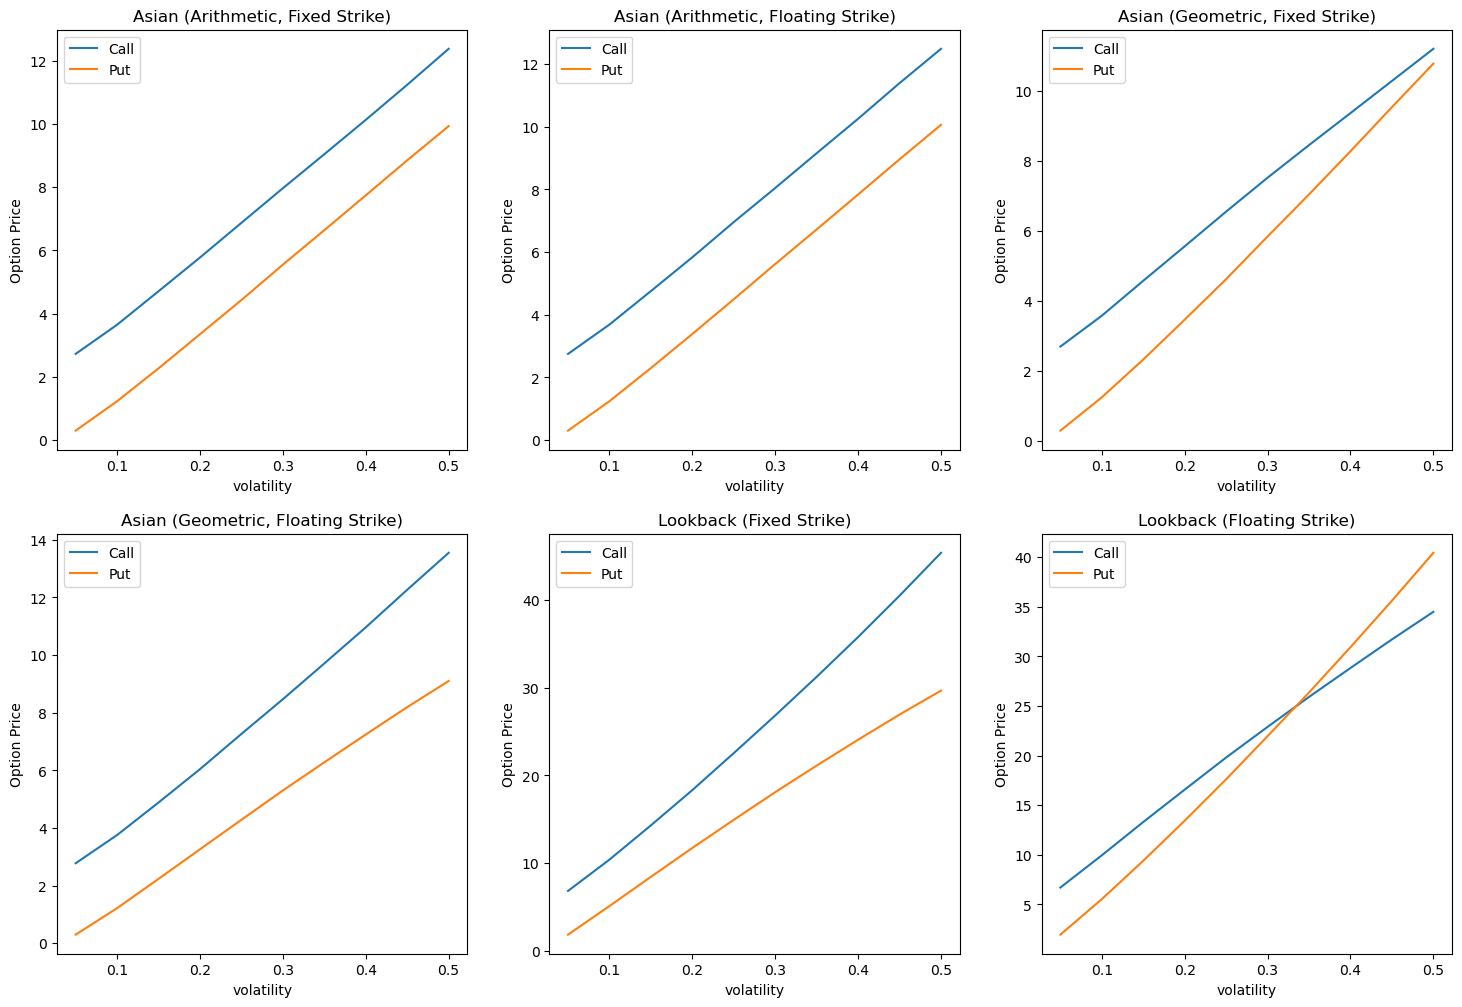

In [15]:
test_option_sensitivity('volatility', 0.05, 0.5, 0.05)  # Test volatilities from 5% to 50% with a step size of 5%

##### Volatility - Comparison, observations & problems

The output aligns with standard option pricing theory, with higher volatility it is more likeley the call with end up in the money and thus becomes more valuable and we can see this across the 6 different option types for both puts and calls.
There are 2 particularly interesting observations both relating to the loockback options:
1. For fixed strikes the call option increases in value at a more rapid pace than the put making the call price much higher than the put at higher volatilites.  
2. For floating strike we see the opposite, which results in the only case in all of the scenario/option combinations where the put becomes more valuable than the call which happens when volatility is greater than 35%.

Conceptually this rate of change difference between floating/fixed strike makes sense at higher volatilities, given that there is unlimited upside in a stock option but a stock can only go to 0. With the fixed strike scenario the high volaitily gives a big upside while the fixed strike doesn't benefit the put as much comparitavly. And the floating put does not have the same limitation, it allows the seller to sell at the maximum stock price during the life of the option which means it too has unlimited upside and benefits much more from higher volatilities compared to its fixed counterpart.

### Testing sensitivity to interest rate

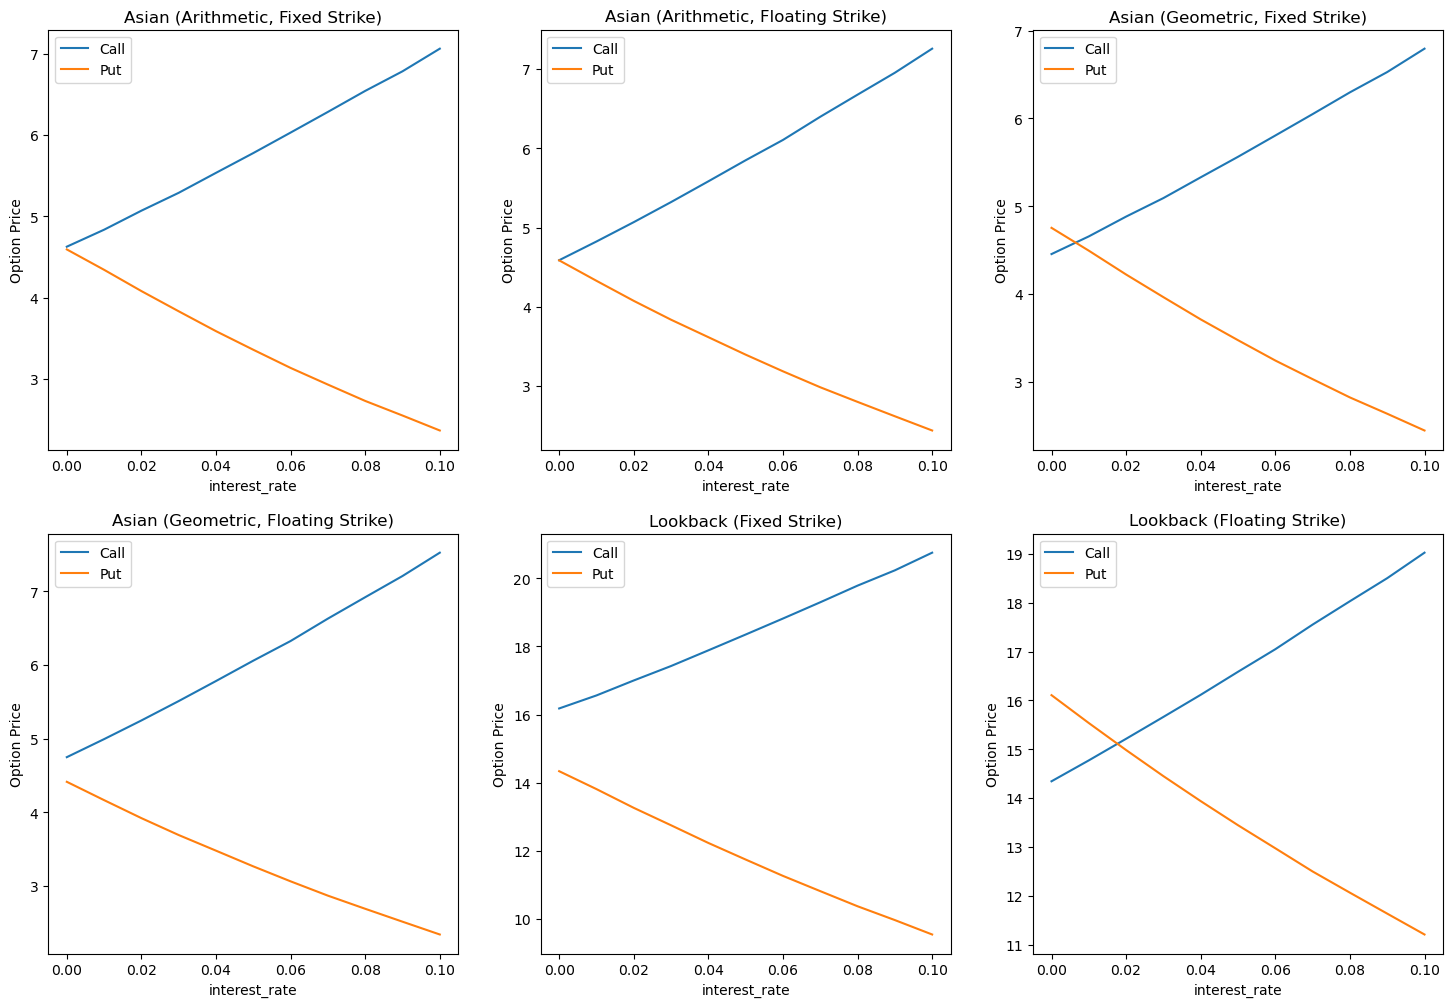

In [18]:
test_option_sensitivity('interest_rate', 0, 0.1, 0.01)  # Test interest rates from 0% to 10% with a step size of 1%

##### Interest rate (drift) - Comparison, observations & problems

As expected increasing drift leads to higher values for calls and lower values for puts across the different option types. This  aligns with standard option pricing theory, higher drift implies that the underlying asset is expected to increase in value over time, benefiting call options while reducing the potential payoff for puts.  
Something that stands out is for lookback floating the change in the puts value decreases at a high rate, the put strike is set at the maximum price of the asset during the life of the option. As the drift increases, this maximum price moves higher, reducing the likelihood of the final price being lower than the strike and thus decreasing the puts value at a quick rate.

### Testing sensitivity to strike price

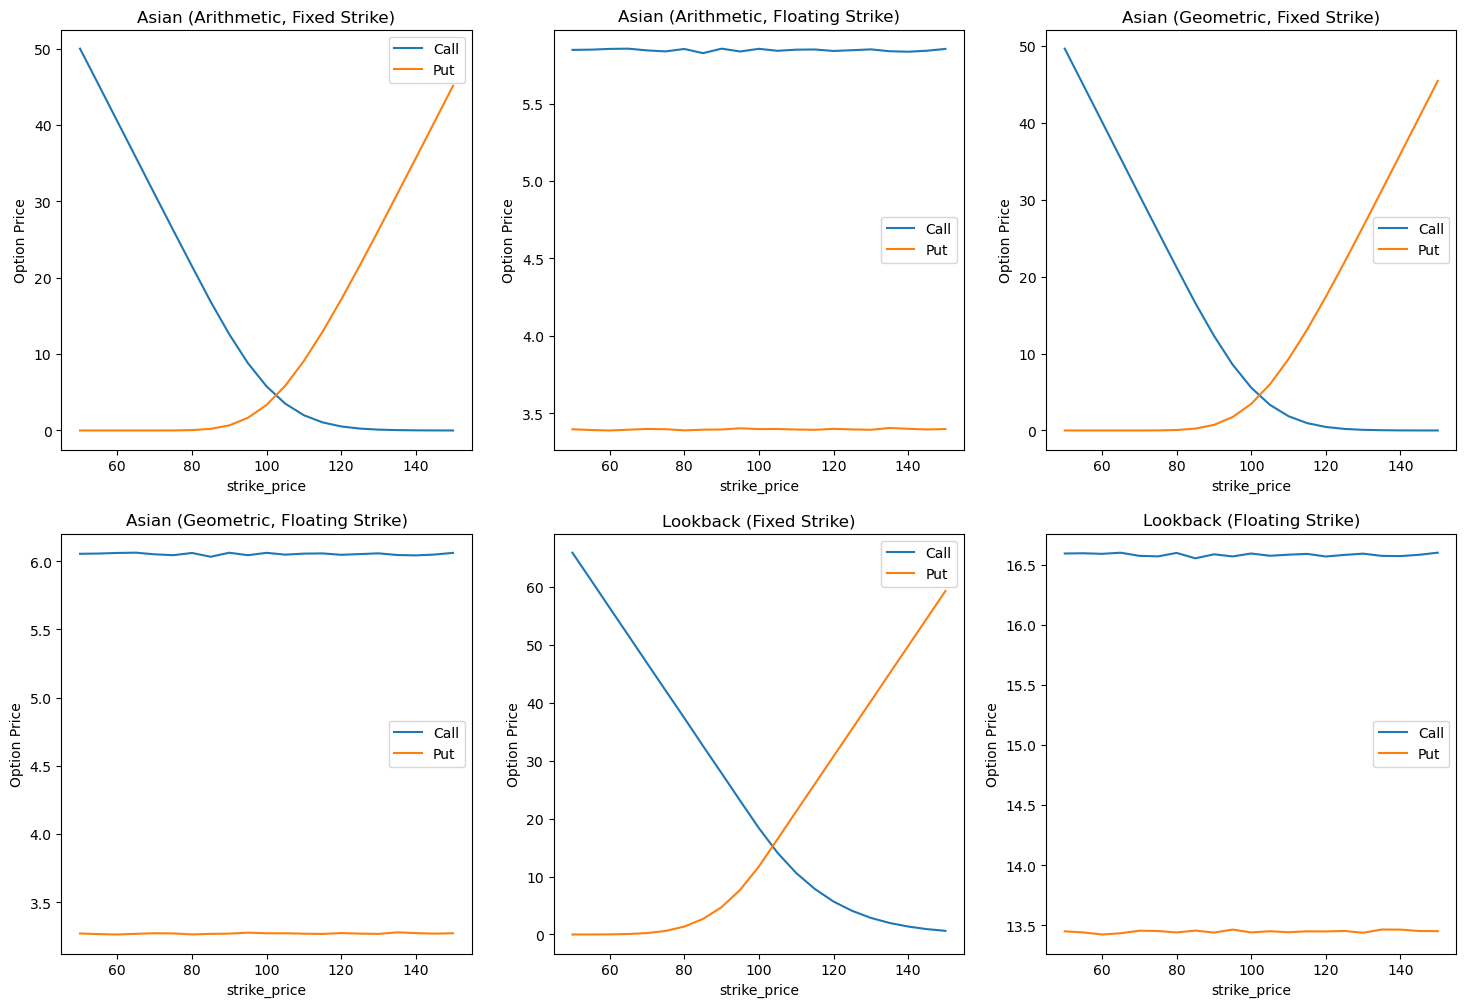

In [21]:
test_option_sensitivity('strike_price', 50, 150, 5)  # Test strike prices from 50 to 150 with a step size of 5

##### Strike price - Comparison, observations & problems

Floating strike options actually don't use the strike price parameter, the graphs for floating strike versions here therefore don't really mean anything sensible here since strike price is not something we can vary on these options, so there is no sensitivity to strike price. The slight variations in the graphs are just due to random noise.  
For fixed strike options, higher strike prices decrease the value of calls (since they make it harder for the option to finish in-the-money) and increase the value of puts (since the underlying asset is more likely to end up below the higher strike price).  

### Testing sensitivity to stock price

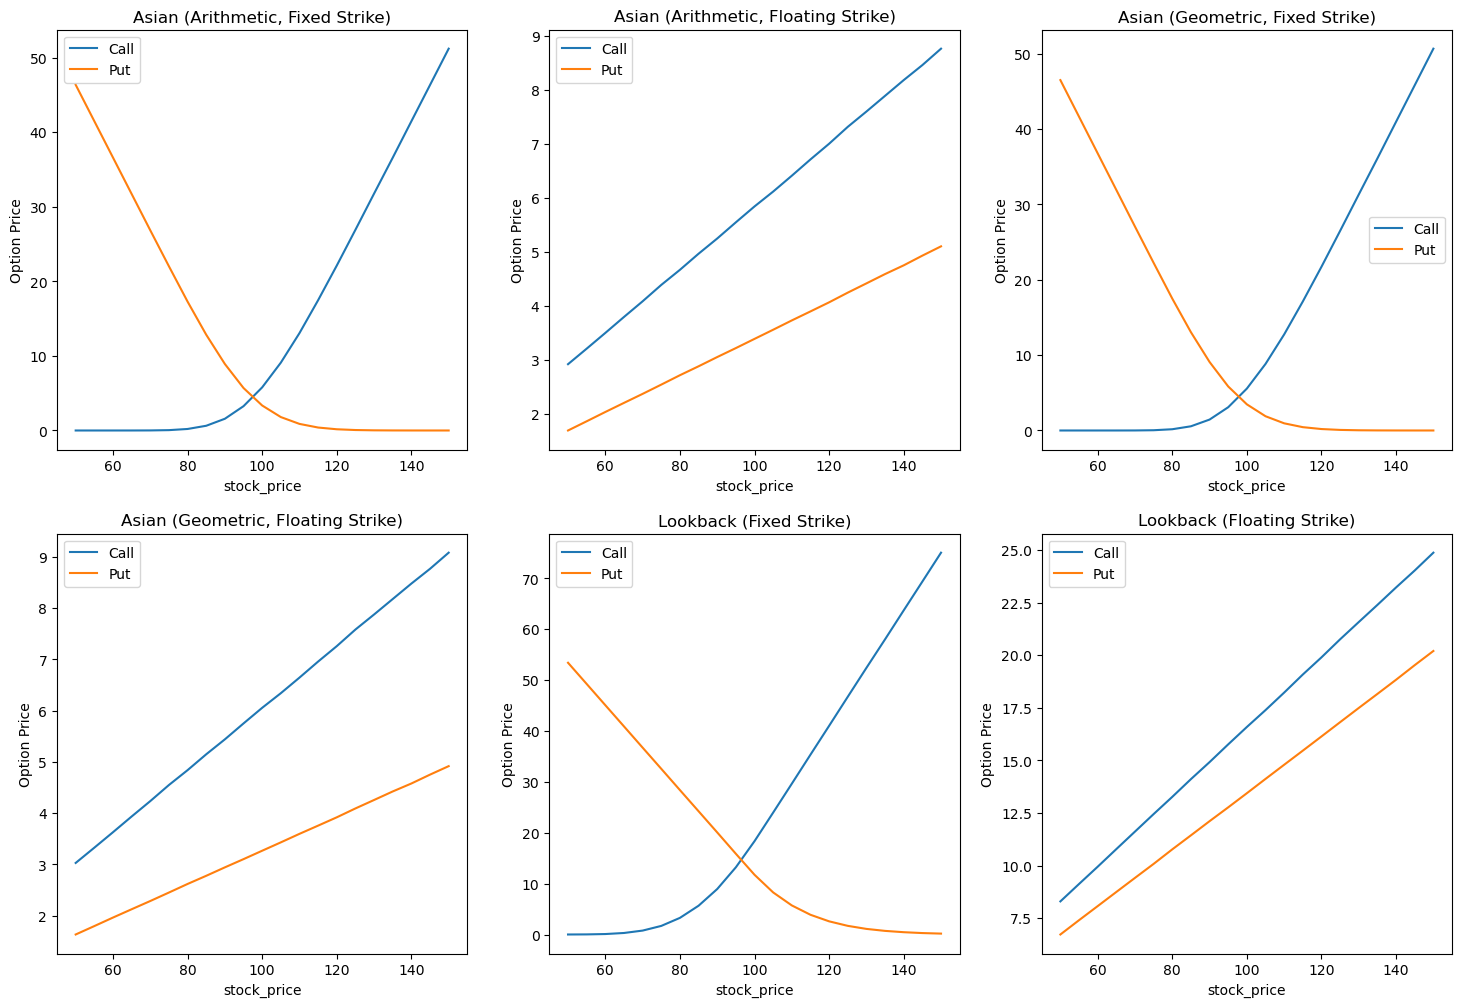

In [24]:
test_option_sensitivity('stock_price', 50, 150, 5)  # Test stock prices from 50 to 150 with a step size of 5

##### Stock price - Comparison, observations & problems

The sensitivity of option prices to changes in the underlying stock price follows standard option pricing behaviour for the fixed strike versions, as the stock price increases (in comparison to the strike that is now kept fixed at 100), call option values rise while put option values fall. However this is not what we see for floating strike options, again becuase they do not have a fixed strike, the strike is a function of the path of the option, this results in both calls and puts moving in the same direction for these options, as the stock price increases both the call and the put increases in value.
I would not have guessed that floating strike calls and puts increase in value with stock price, my hupothesis was that it would stay flat. What could explain this behavior is that the higher price movements results in the same % change as lower stock prices, but that same % results in a higher payoff at higher stock prices. Say the stock price starts at 50 and increases by 20% to 60, verses a stock price that starts at 100 and increases by 20% to 120, even though in both scenariors the stock price changed by 20% the change in price was twice as much 10 vs 20. That 20 change would result in a bigger payoff than the 10 change.

### Testing sensitivity to time to expiry

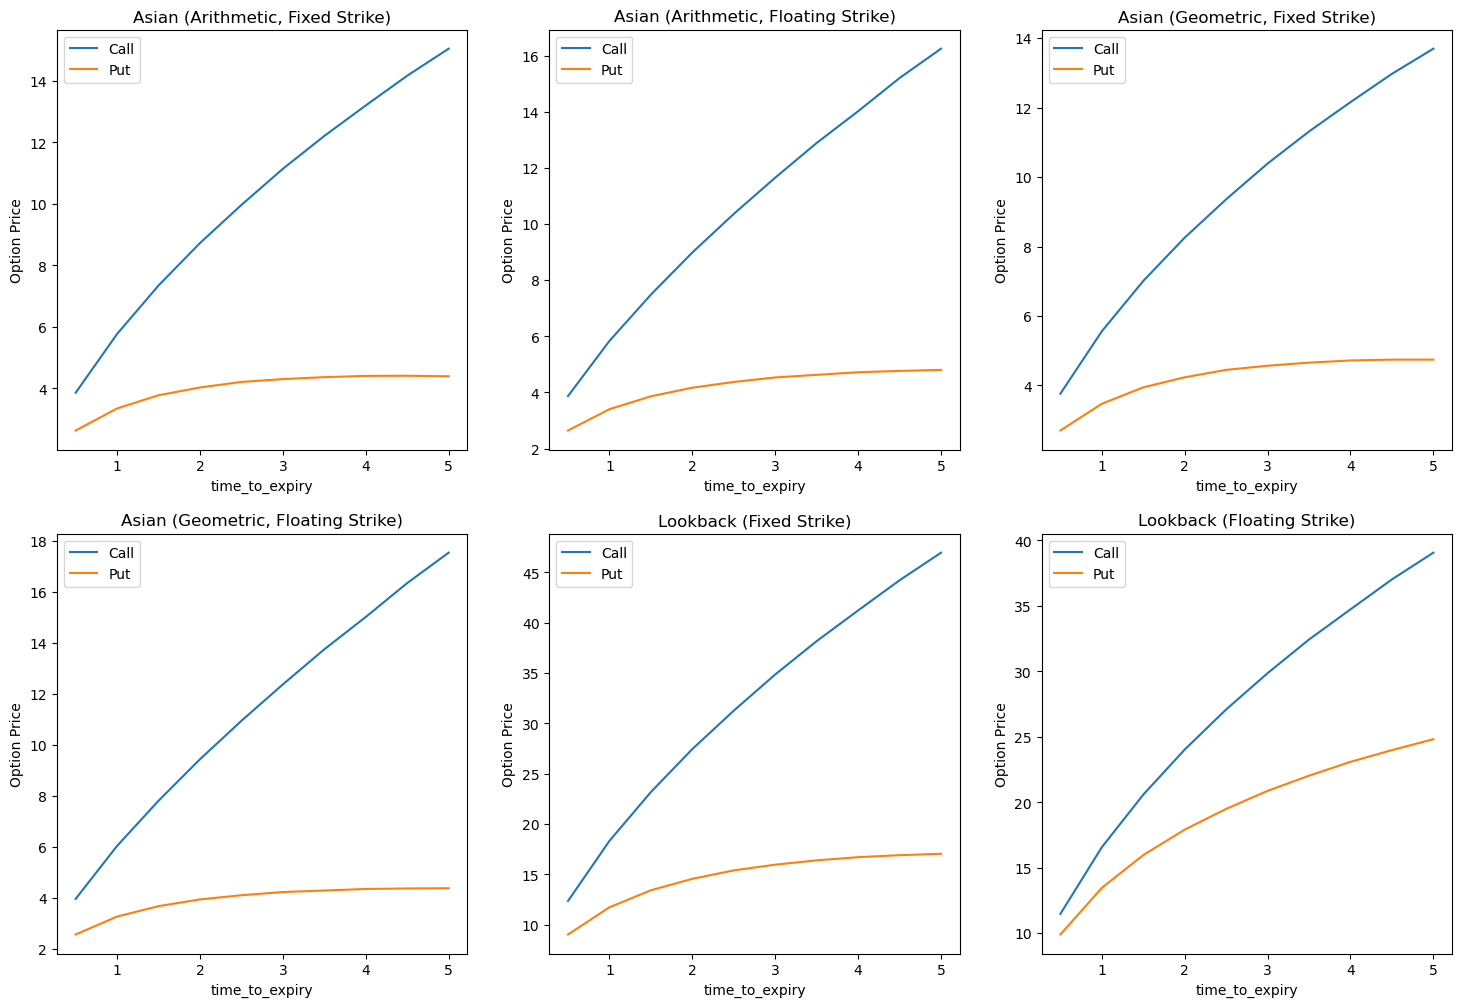

In [27]:
test_option_sensitivity('time_to_expiry', 0.5, 5, 0.5)  # Test time to expiry from 0.5 to 5 years with a step size of 0.5 years

##### Time to expiry - Comparison, observations & problems

Time to expiry sensitivity follows the classic option pricing intuition, both call and put values tend to increase with more time to expiry. This is because the more time that remains until the option expires, the greater the potential for the underlying asset to fluctuate, increasing the likelihood of finishing in the money and of larger payoffs for both calls and puts.  
For floating lookback the put price sticks out at benefiting from longer expiry much more than other put options. This is because the strike price in floating lookback options is dynamically set to the maximum price  during the options life. With more time to expiry, there is greater potential for the stock price to swing widely,  and for this option to have more upside than other put options.

## Conclusion

In this project, I have used the Euler-Maruyama scheme to simulate stock prices following geometric Brownian motion following the steps outlined by Singaravelu (2024), and Ahmad (2024). And then explored the expected payoffs of Asian and Lookback options. I considered several different versions of these exotic options and examined the sensitivities of option value with regards to volatility, interest rate, strike price, stock price, and time to expiry on option values.

Across all scenarios, Lookback options proved to be more expensive than Asian options. This is expected since they give the holder the right to the optimal stock price during the option’s life. Call prices generally exceeded put prices, driven by the positive drift, making the average expected stock price higher than it is initially.

For Asian options, those based on the geometric average were cheaper than their arithmetic counterparts, reflecting the geometric average tendency to be lower, which reduces the potential payoff. Volatility sensitivity showed that increasing volatility raises both call and put values across all option types, but with Lookback Fixed Strike options, the call prices increased significantly more than the put prices. This is because the unlimited upside potential for calls in a volatile environment benefits them more than puts. Interestingly with lookback floating strike options, the put became more valuable than the call at higher volatility levels (above 35%) due to the puts ability to sell at the maximum stock price during the option life, making it veryvaluable in high volatility markets.

For stock price sensitivity for floating strike options, both calls and puts increased in value with rising stock prices. This is seems counterintuitive but can be explained by the path-dependent nature of floating strike options,  a higher starting price allows for greater fluctuations, increasing potential payoffs for both options.

Lastly, time to expiry sensitivity showed that longer expiry benefited both calls and puts, as more time allowed for greater price fluctuations. This effect was particularly noticeable for lookback floating strike puts, where the strike price is set by the maximum price during the option life. More time increases the potential for extreme price swings, leading to larger potential payoffs.

Overall the results align with standard option pricing theory but highlight some unique characteristics of exotic options. Strong path dependent options like Lookback and Asian options introduce interesting sensitivities, especially in floating strike scenarios.

## References

Dr. Riaz Ahmad (2024). Intro To Numerical Methods [JU243.4 Annotated.pdf]. Certificate in Quantitative Finance (CQF) [https://learn.cqf.com/].  
Dr. Riaz Ahmad (2024). Exotic Options [JU243.5 Notes.pdf]. Certificate in Quantitative Finance (CQF) [https://learn.cqf.com/].  
Kannan Singaravelu (2024). Monte Carlo Simulation [JU24P6 Monte Carlo Simulation.html]. Certificate in Quantitative Finance (CQF) [https://learn.cqf.com/].  


